In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression

In [2]:
pickle_off = open ("return_1d.pkl", "rb")
return_1d = pickle.load(pickle_off)
return_1d.head()

,Nifty_50_1d_return,Dow_Jons_1d_return,SPX_500_1d_return,NASDAQ_1d_return,BRENT_1d_return,BOND_10Y_1d_return,Gold_1d_return,Inr_Usd_1d_return,Dollar_Index_1d_return,Bank_Nifty_1d_return,Nifty_IT_1d_return,Nifty_Auto_1d_return,Nifty_Metal_1d_return,Nifty_FMGC_1d_return,Nifty_Energy_1d_return,NIFTY_FIN_SERVICE_1d_return,Nifty_Infra_1d_return,Nifty_CMDT_1d_return,Nifty_Consumer_1d_return
Date,,,,,,,,,,,,,,,,,,,
08-09-11,-0.53,-1.42,-1.37,-1.26,-1.42,-1.81,-1.74,-1.00,-2.71,-0.70,8.26,0.42,-1.46,-0.27,-0.34,-1.00,-0.83,-0.81,-1.19
13-09-11,-0.95,-0.36,0.31,0.35,-0.30,1.97,-1.37,0.01,-2.73,-0.80,-1.27,1.72,0.03,-0.86,-1.16,0.42,-0.88,-0.26,0.88
14-09-11,-13.25,2.14,0.48,0.07,-2.42,-0.68,-1.19,-0.43,-0.88,-3.40,3.66,-0.71,-1.07,-91.91,3.21,-0.79,0.02,-1.14,-0.63
15-09-11,-0.13,0.31,0.28,-0.16,4.74,2.96,12.66,-0.67,6.38,0.40,-0.46,-5.15,8.29,-1.20,-0.03,-2.90,-2.51,5.99,-3.54
16-09-11,-0.87,-0.60,-0.67,-0.56,-2.03,-1.12,-1.77,-1.60,-1.58,-0.69,-1.44,-0.69,-0.91,3.86,-0.64,1.62,0.43,-0.60,-1.61


In [3]:
# Add lagged returns as features
return_1d['Nifty_Energy_1d_return'] = return_1d['Nifty_Energy_1d_return'].shift(1)
return_1d['Nifty_50_1d_return_lag1'] = return_1d['Nifty_50_1d_return'].shift(1)
return_1d = return_1d.dropna()
return_1d['return_squared'] = return_1d['Nifty_Energy_1d_return'] ** 2
return_1d['return_lag_interaction'] = return_1d['Nifty_Energy_1d_return'] * return_1d['Nifty_50_1d_return_lag1']
# Detect and remove outliers using IQR
q1 = return_1d['Nifty_Energy_1d_return'].quantile(0.25)
q3 = return_1d['Nifty_Energy_1d_return'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
return_1d = return_1d[(return_1d['Nifty_Energy_1d_return'] >= lower_bound) & (return_1d['Nifty_Energy_1d_return'] <= upper_bound)]
np.random.seed(42)

In [4]:
# Display the cleaned data
print("Cleaned data:")
print(return_1d.head())

Cleaned data:
          Nifty_50_1d_return  Dow_Jons_1d_return  SPX_500_1d_return  \
Date                                                                  
13-09-11               -0.95               -0.36               0.31   
14-09-11              -13.25                2.14               0.48   
16-09-11               -0.87               -0.60              -0.67   
19-09-11               -7.11               -2.41              -2.72   
20-09-11               -3.09               -1.07              -0.83   

          NASDAQ_1d_return  BRENT_1d_return  BOND_10Y_1d_return  \
Date                                                              
13-09-11              0.35            -0.30                1.97   
14-09-11              0.07            -2.42               -0.68   
16-09-11             -0.56            -2.03               -1.12   
19-09-11             -1.62             0.01               13.07   
20-09-11              1.39            -1.47               -1.08   

          Gold_1d_

In [5]:
# Display the statistics of the cleaned data
print("Statistics of the cleaned data:")
print(return_1d.describe())

Statistics of the cleaned data:
       Nifty_50_1d_return  Dow_Jons_1d_return  SPX_500_1d_return  \
count         1799.000000         1799.000000        1799.000000   
mean            -2.062329           -2.476237           0.299978   
std             71.339643          135.488110          44.786663   
min          -2807.010000        -3606.010000        -363.000000   
25%             -1.930000           -1.820000          -1.955000   
50%             -0.910000           -1.000000          -1.000000   
75%              0.205000           -0.030000          -0.060000   
max            786.820000         3322.270000        1128.740000   

       NASDAQ_1d_return  BRENT_1d_return  BOND_10Y_1d_return  Gold_1d_return  \
count       1799.000000      1799.000000         1799.000000     1799.000000   
mean          -2.253407        -2.162735           -0.998071       -0.670556   
std           55.486273        22.904415            2.335837       12.615285   
min         -970.740000      -426.1

In [6]:
# Correlation analysis
corr_matrix_1d = return_1d.corr()
nifty_corr_1d = pd.DataFrame(return_1d.corr()['Nifty_Energy_1d_return'].sort_values())
nifty_corr_1d

,Nifty_Energy_1d_return
return_squared,-0.607061
Dow_Jons_1d_return,-0.025846
Nifty_Consumer_1d_return,-0.020375
Nifty_Metal_1d_return,-0.020162
Gold_1d_return,-0.017372
BRENT_1d_return,-0.016420
Bank_Nifty_1d_return,-0.012899
Nifty_FMGC_1d_return,-0.005404
return_lag_interaction,-0.004850
Nifty_Auto_1d_return,-0.000048


<Axes: >

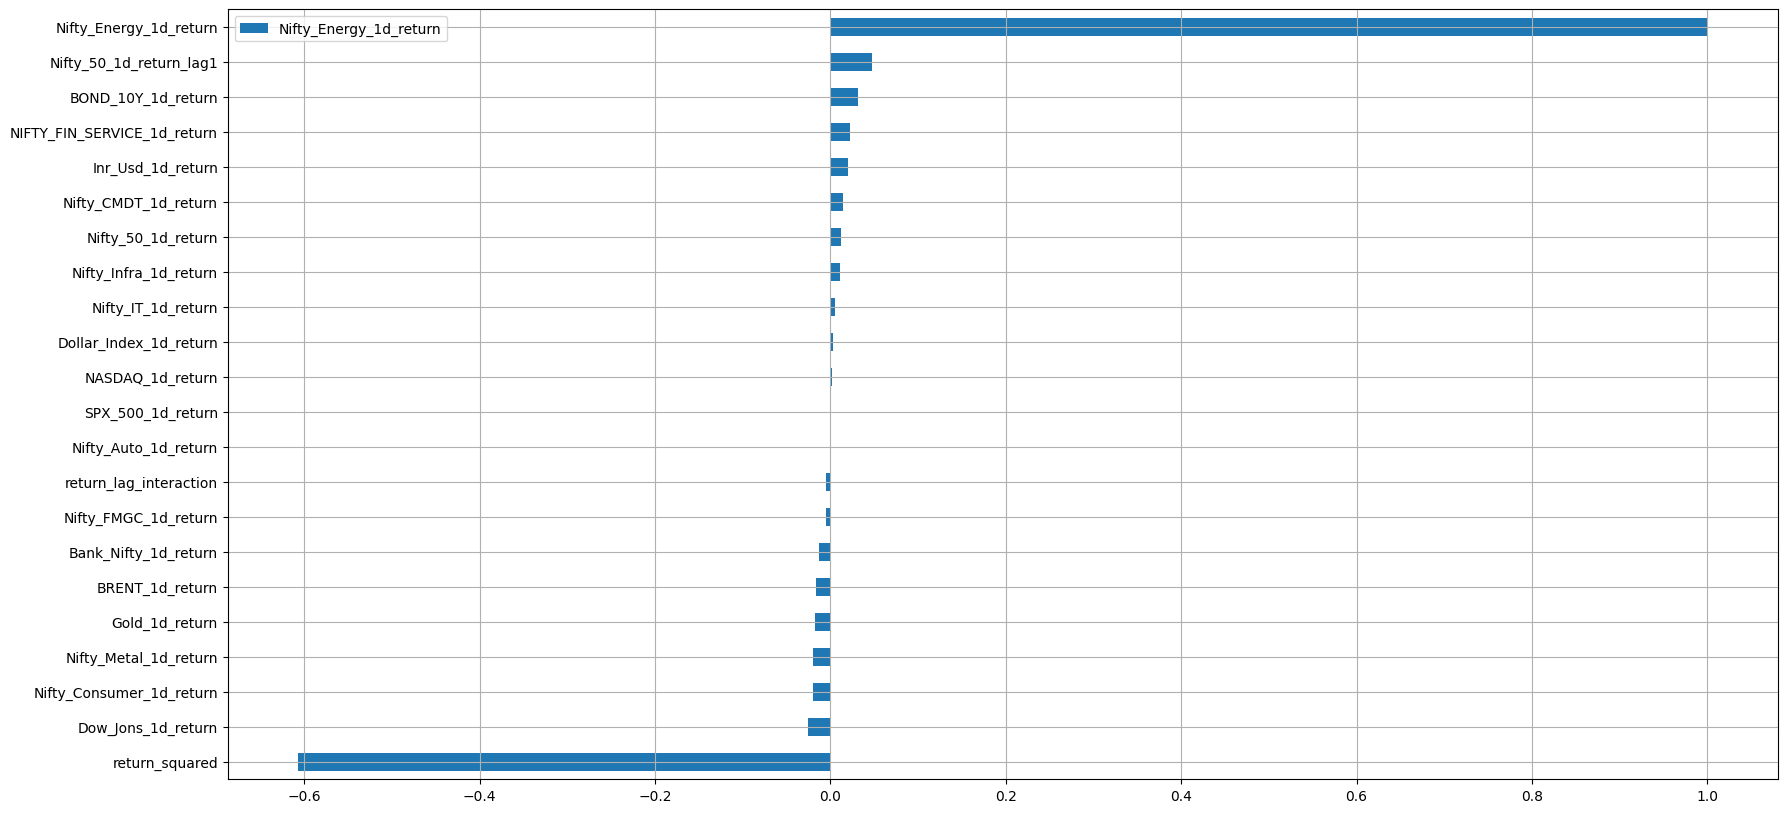

In [7]:
filter = np.abs(nifty_corr_1d)  # this creates a float64 array
mask = filter >= -1  # this creates a boolean mask based on the condition
nifty_corr_1d[mask].plot.barh(figsize=(20,10), grid=True)  # use the boolean mask to index the DataFrame

In [8]:
# Feature selection using mutual information
selector = SelectKBest(score_func=mutual_info_regression, k='all')
X = return_1d.drop(columns='Nifty_Energy_1d_return')
y = return_1d['Nifty_Energy_1d_return']
X_new = selector.fit_transform(X, y)
print('Selected features:', X.columns[selector.get_support()])

Selected features: Index(['Nifty_50_1d_return', 'Dow_Jons_1d_return', 'SPX_500_1d_return',
       'NASDAQ_1d_return', 'BRENT_1d_return', 'BOND_10Y_1d_return',
       'Gold_1d_return', 'Inr_Usd_1d_return', 'Dollar_Index_1d_return',
       'Bank_Nifty_1d_return', 'Nifty_IT_1d_return', 'Nifty_Auto_1d_return',
       'Nifty_Metal_1d_return', 'Nifty_FMGC_1d_return',
       'NIFTY_FIN_SERVICE_1d_return', 'Nifty_Infra_1d_return',
       'Nifty_CMDT_1d_return', 'Nifty_Consumer_1d_return',
       'Nifty_50_1d_return_lag1', 'return_squared', 'return_lag_interaction'],
      dtype='object')


In [9]:
# Feature Scaling
scaler = StandardScaler()
X = return_1d.drop(columns='Nifty_Energy_1d_return')
y = return_1d['Nifty_Energy_1d_return']
X = scaler.fit_transform(X_new)
y = y.astype('float32')
print(X[-5:])
print(y[-5:])

[[ 2.73742878e-02  6.66386631e-02 -3.12675010e-02  6.55132296e-03
  -7.15420218e+00 -6.47455054e-01 -9.90696254e-02  9.25428564e-02
  -6.59476620e-02 -3.39917185e+00 -7.91504923e-02 -2.64769282e-02
   4.69104615e-02 -2.18280301e-02 -3.77277150e-02  2.78786728e-03
  -1.45408316e-02  1.43598602e-01 -2.05474257e-02  3.23824164e-01
  -1.46462166e-02]
 [ 1.29322981e-02  2.11607775e-02  1.54910644e+00 -4.38186775e-01
   1.05368582e-01 -7.07407417e-01 -1.06998721e-01  3.35776291e-01
  -6.11179344e-02 -1.10301570e-01  2.19310639e-02 -4.12266493e-01
  -3.49643122e-02 -1.81180435e-02  2.43213677e-02 -9.50144846e-02
  -3.19773054e-02 -5.95855248e-02 -5.22433179e-03 -6.08595918e-01
  -3.30938692e-02]
 [ 1.39137925e-02  9.42216739e-03 -3.23842152e-02  2.02522129e-02
   3.85506595e-02 -1.76400771e-01 -2.04526603e-01 -1.78488684e-01
   2.82320265e-02 -1.32002327e-01 -1.01251926e-01 -1.68147242e-01
   8.68423686e-02 -3.96687011e-02 -5.64573455e-02 -7.61403465e-02
   3.79202112e-02 -3.07346065e-02 -3.6

Data Cleaning And Transformation Completed

Model Building for Features Importance

In [10]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Define regression models
dtr = DecisionTreeRegressor(max_depth=5)
rfr = RandomForestRegressor(n_estimators=50, random_state=2)
etr = ExtraTreesRegressor(n_estimators=50, random_state=2)
gbr = GradientBoostingRegressor(n_estimators=50, random_state=2)
xgbr = XGBRegressor(n_estimators=50, random_state=2)

In [12]:
regressors = {
    'DTR': dtr,
    'RFR': rfr,
    'ETR': etr,
    'GBR': gbr,
    'XGBR': xgbr
}

In [13]:
def train_regressor(regressor, X_train, y_train, X_test, y_test):
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [14]:
mse_scores = []
r2_scores = []
for name, regressor in regressors.items():
    current_mse, current_r2 = train_regressor(regressor, X_train, y_train, X_test, y_test)
    print(f"For {name}:")
    print(f"MSE: {current_mse:.4f}")
    print(f"R2: {current_r2:.4f}\n")
    mse_scores.append(current_mse)
    r2_scores.append(current_r2)

For DTR:
MSE: 0.4446
R2: 0.7834

For RFR:
MSE: 0.1749
R2: 0.9148

For ETR:
MSE: 0.5921
R2: 0.7115

For GBR:
MSE: 0.3352
R2: 0.8367

For XGBR:
MSE: 0.1587
R2: 0.9227



In [15]:
scaler = StandardScaler()
# Find the index of the model with the lowest MSE score
best_model_index = np.argmin(mse_scores)
# Get the name of the best model
best_model_name = list(regressors.keys())[best_model_index]
# Print the name of the best model
print(f"The best model is {best_model_name} with an MSE of {mse_scores[best_model_index]:.4f}.")
# Train the best model on the full dataset
best_model = regressors[best_model_name]
best_model.fit(scaler.fit_transform(X), y)

The best model is XGBR with an MSE of 0.1587.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=2, ...)

The best model is XGBR with an MSE of 0.1587.

In [16]:
y_pred = etr.predict(X_test)
df_1d = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df_1d

,Actual,Predicted
Date,,
21-11-18,-1.85,-1.7832
27-12-12,-3.54,-3.5424
10-02-22,-1.04,-0.5362
04-04-14,-1.55,-1.1868
14-07-17,-0.81,-0.5376
...,...,...
05-12-22,-0.09,-0.0428
16-02-18,0.78,-0.1142
03-06-22,-3.79,-3.7872


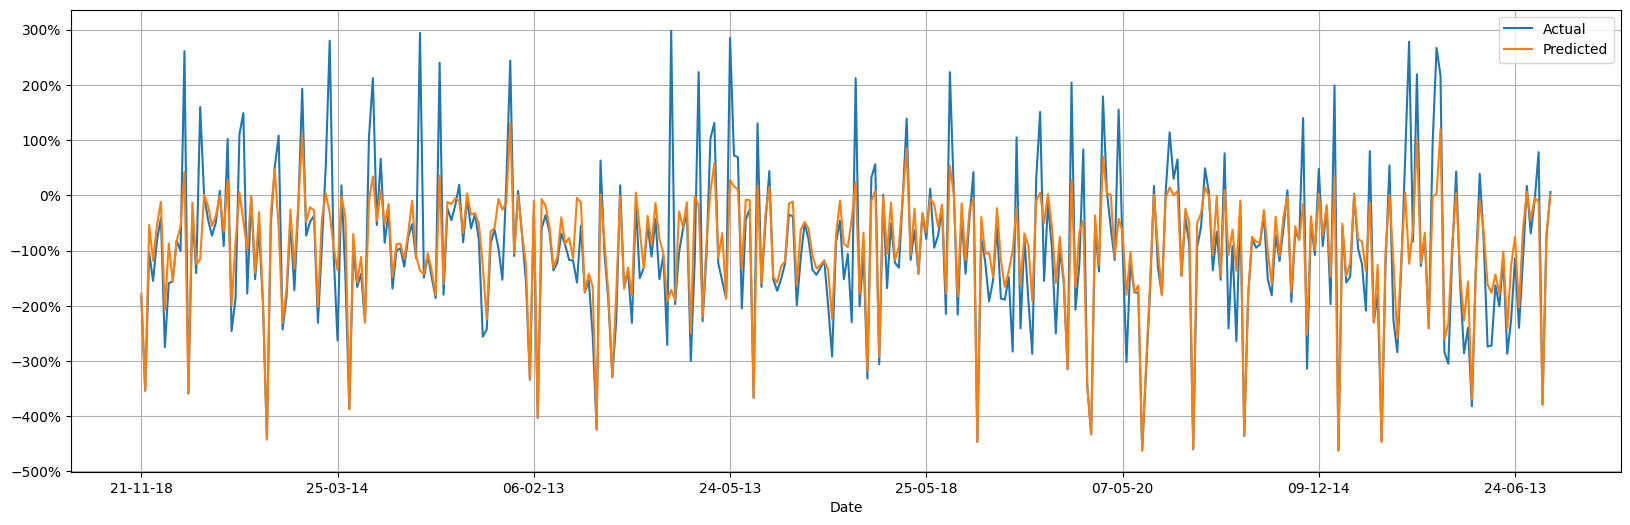

In [17]:
ax = df_1d.plot(figsize=(20,6), grid=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

C:\Users\Harsh\AppData\Local\Temp\ipykernel_18060\3094767840.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-y_pred)


<Axes: xlabel='Nifty_Energy_1d_return', ylabel='Density'>

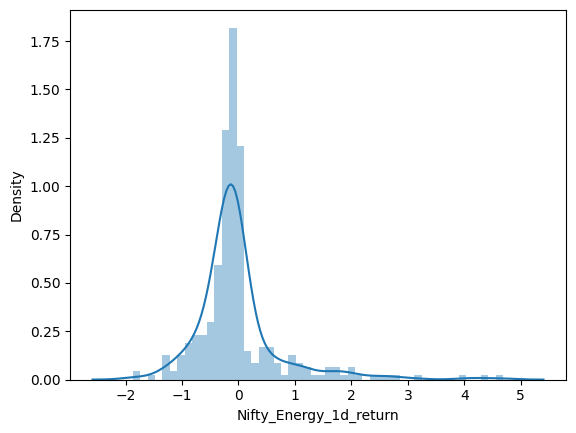

In [18]:
sns.distplot(y_test-y_pred)

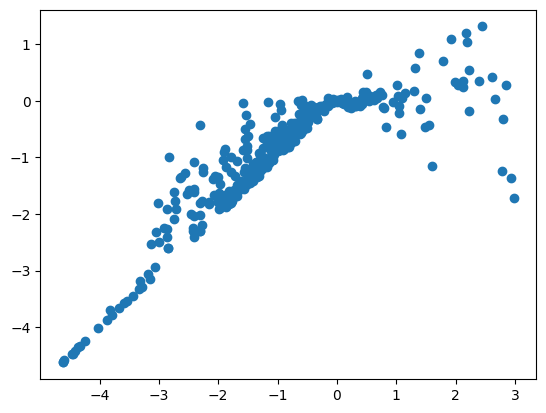

In [19]:
plt.scatter(y_test,y_pred)
